# 肺野セグメンテーション

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
IMAGE_DIR = 'regular'
LABEL_DIR = 'lung'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, image_dir, label_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(image_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['image_path'])
    df['label_path'] = df['image_path'].map(
        lambda p: root / pathlib.Path(label_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, IMAGE_DIR, LABEL_DIR, IMAGE_EXT)
display(df_dataset)

,image_path,label_path
0,Data\Images\chest_xray\regular\000.png,Data\Images\chest_xray\lung\000.png
1,Data\Images\chest_xray\regular\001.png,Data\Images\chest_xray\lung\001.png
2,Data\Images\chest_xray\regular\002.png,Data\Images\chest_xray\lung\002.png
3,Data\Images\chest_xray\regular\003.png,Data\Images\chest_xray\lung\003.png
4,Data\Images\chest_xray\regular\004.png,Data\Images\chest_xray\lung\004.png
...,...,...
280,Data\Images\chest_xray\regular\280.png,Data\Images\chest_xray\lung\280.png
281,Data\Images\chest_xray\regular\281.png,Data\Images\chest_xray\lung\281.png
282,Data\Images\chest_xray\regular\282.png,Data\Images\chest_xray\lung\282.png
283,Data\Images\chest_xray\regular\283.png,Data\Images\chest_xray\lung\283.png


### 画像を表示
入力画像を背景にセグメンテーションを重畳表示する

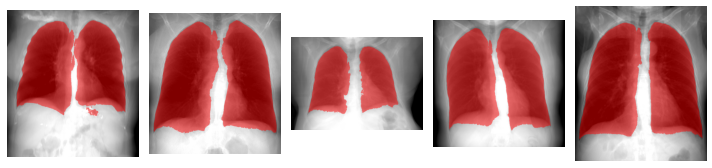

In [4]:
OVERLAY_ALPHA = 0.5
cmap = np.array([[0, 0, 0, 0], [255, 0, 0,
                                255 * OVERLAY_ALPHA]]).astype(np.uint8)

N_SAMPLES = 5
plt.figure(figsize=(10, 5))
for i, sample in enumerate(df_dataset.sample(n=N_SAMPLES).itertuples()):
    image = Image.open(sample.image_path).convert('RGBA')
    label = np.array(Image.open(sample.label_path).convert('L'))
    label = (label > 0).astype(np.uint8)
    label = Image.fromarray(cmap[label])
    plt.subplot(1, N_SAMPLES, i + 1)
    plt.imshow(Image.alpha_composite(image, label))
    plt.axis('off')
plt.tight_layout()
plt.show()

### Data augmentation
回転、左右反転等をランダムに適用する。

In [5]:
import tqdm
IMG_SHAPE = (3, 256, 256)


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)


def load_img2img_dataset(df, load_img):
    data = np.stack(
        [load_img(filepath) for filepath in tqdm.tqdm(df['image_path'])])
    labels = np.stack([
        load_img(filepath)[..., :1] for filepath in tqdm.tqdm(df['label_path'])
    ])
    return data, labels

100%|██████████| 3/3 [00:00<00:00, 598.53it/s]


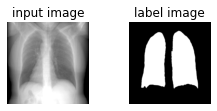

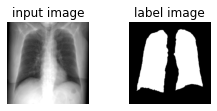

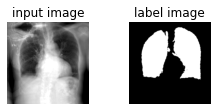

In [6]:
import albumentations as A
from tut_utils import AugmentedDataset
from torch.utils.data import DataLoader

album_transform = A.Compose([
    A.HorizontalFlip(p=.25),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=.1, rotate_limit=5, p=.8)
])


def random_transform(x, y):
    x = (x / 255).astype(np.float32)
    y = (y / 255).astype(np.float32)
    tfed = album_transform(image=x, mask=y)
    x, y = tfed['image'], tfed['mask']
    x, y = x.transpose(2, 0, 1), y.transpose(2, 0, 1)  # to channels first
    return x.astype(np.float32), y.astype(np.float32)


N_TEST = 3


def test_augmentation(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    train_data, train_labels = load_img2img_dataset(df_train, load_img)
    dataset = AugmentedDataset(train_data, train_labels, random_transform)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    for i, data in enumerate(loader):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(data[0].squeeze().numpy(), cmap='gray')
        plt.title('input image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(data[1].squeeze().numpy(), cmap='gray')
        plt.title('label image')
        plt.axis('off')
        plt.show()


test_augmentation(df_dataset)

### ホールドアウト
学習に時間がかかるため、今回は交差検証は行わない。

In [7]:
from sklearn.model_selection import KFold
N_SPLITS = 5
kfold = KFold(n_splits=N_SPLITS, shuffle=True)
train_index, test_index = next(kfold.split(df_dataset['image_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]
print('training:', len(df_train), 'test:', len(df_test))

training: 228 test: 57


## モデル作成
[U-Net](https://arxiv.org/abs/1505.04597)

In [8]:
IN_CHS = 1
OUT_CHS = 1
UNET_DEPTH = 4

import torch
import torch.nn as nn


class ConvBNReLU(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_chs,
                      out_chs,
                      kernel_size=kernel_size,
                      padding=padding), nn.BatchNorm2d(out_chs),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.block(x)


class Encoder(nn.Module):
    def __init__(self, in_chs: int, mid_chs: int, out_chs: int,
                 kernel_size: int, padding: int):
        super().__init__()
        self.out_chs = out_chs
        self.block = nn.Sequential(
            ConvBNReLU(in_chs, mid_chs, kernel_size, padding),
            ConvBNReLU(mid_chs, out_chs, kernel_size, padding),
        )

    def forward(self, x):
        return self.block(x)


class Decoder(nn.Module):
    def __init__(self,
                 in_chs,
                 out_chs,
                 kernel_size,
                 padding,
                 scale_factor: int,
                 apply_dropout=False):
        super().__init__()
        self.out_chs = out_chs
        mid_chs = (in_chs + out_chs) // 2
        self.up = nn.Upsample(scale_factor=scale_factor,
                              mode='bilinear',
                              align_corners=True)
        self.block = nn.Sequential(
            ConvBNReLU(in_chs, mid_chs, kernel_size, padding),
            ConvBNReLU(mid_chs, out_chs, kernel_size, padding),
        )

        if apply_dropout:
            self.dropout = nn.Dropout(.25)
        else:
            self.dropout = None

    def forward(self, x1, x2):
        cat = torch.cat([self.up(x1), x2], dim=1)
        x = self.block(cat)
        if self.dropout:
            x = self.dropout(x)
        return x


class UNet(nn.Module):
    def __init__(self,
                 in_chs,
                 out_chs,
                 depth,
                 ini_chs=8,
                 kernel_size=3,
                 padding=1,
                 scale_factor=2):
        '''
        Args:
            depth (int): UNets depth i.e # of downsampling layers
        '''
        super().__init__()
        self.depth = depth
        self.encs = nn.ModuleList()
        self.decs = nn.ModuleList()
        self.pools = nn.ModuleList()
        chs = ini_chs
        for i in range(depth):
            enc = Encoder(in_chs if i == 0 else chs, chs, chs * 2, kernel_size,
                          padding)
            self.encs.append(enc)
            chs = chs * 2
            if i < (depth - 1):
                self.pools.append(nn.MaxPool2d(scale_factor))

        for i in range(depth - 1):
            enc_below = self.encs[-i - 1]
            enc_left = self.encs[-i - 2]
            dec = Decoder(enc_left.out_chs + enc_below.out_chs,
                          enc_left.out_chs,
                          kernel_size,
                          padding,
                          scale_factor,
                          apply_dropout=i < depth // 2)
            self.decs.append(dec)

        self.output_layer = nn.Conv2d(self.decs[-1].out_chs,
                                      out_chs,
                                      kernel_size=1,
                                      padding=0)

    def forward(self, x):
        skips = []
        for i in range(self.depth):
            x = self.encs[i](x)
            if i < (self.depth - 1):
                skips.append(x)
                x = self.pools[i](x)

        for i in range(self.depth - 1):
            x = self.decs[i](x, skips[-(i + 1)])

        return self.output_layer(x)


from torchsummary import summary
summary(UNet(IN_CHS, OUT_CHS, UNET_DEPTH), (1, 512, 512),
        verbose=0,
        device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-1                      [-1, 16, 512, 512]        --
|    |    └─Sequential: 3-1              [-1, 16, 512, 512]        1,296
├─ModuleList: 1                          []                        --
|    └─MaxPool2d: 2-2                    [-1, 16, 256, 256]        --
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-3                      [-1, 32, 256, 256]        --
|    |    └─Sequential: 3-2              [-1, 32, 256, 256]        7,056
├─ModuleList: 1                          []                        --
|    └─MaxPool2d: 2-4                    [-1, 32, 128, 128]        --
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-5                      [-1, 64, 128, 128]        --
|    |    └─Sequential: 3-3              [-1, 64, 128, 128]        27,936
├─Mod

### ネットワーク構造の可視化
スキップコネクションを確認する。

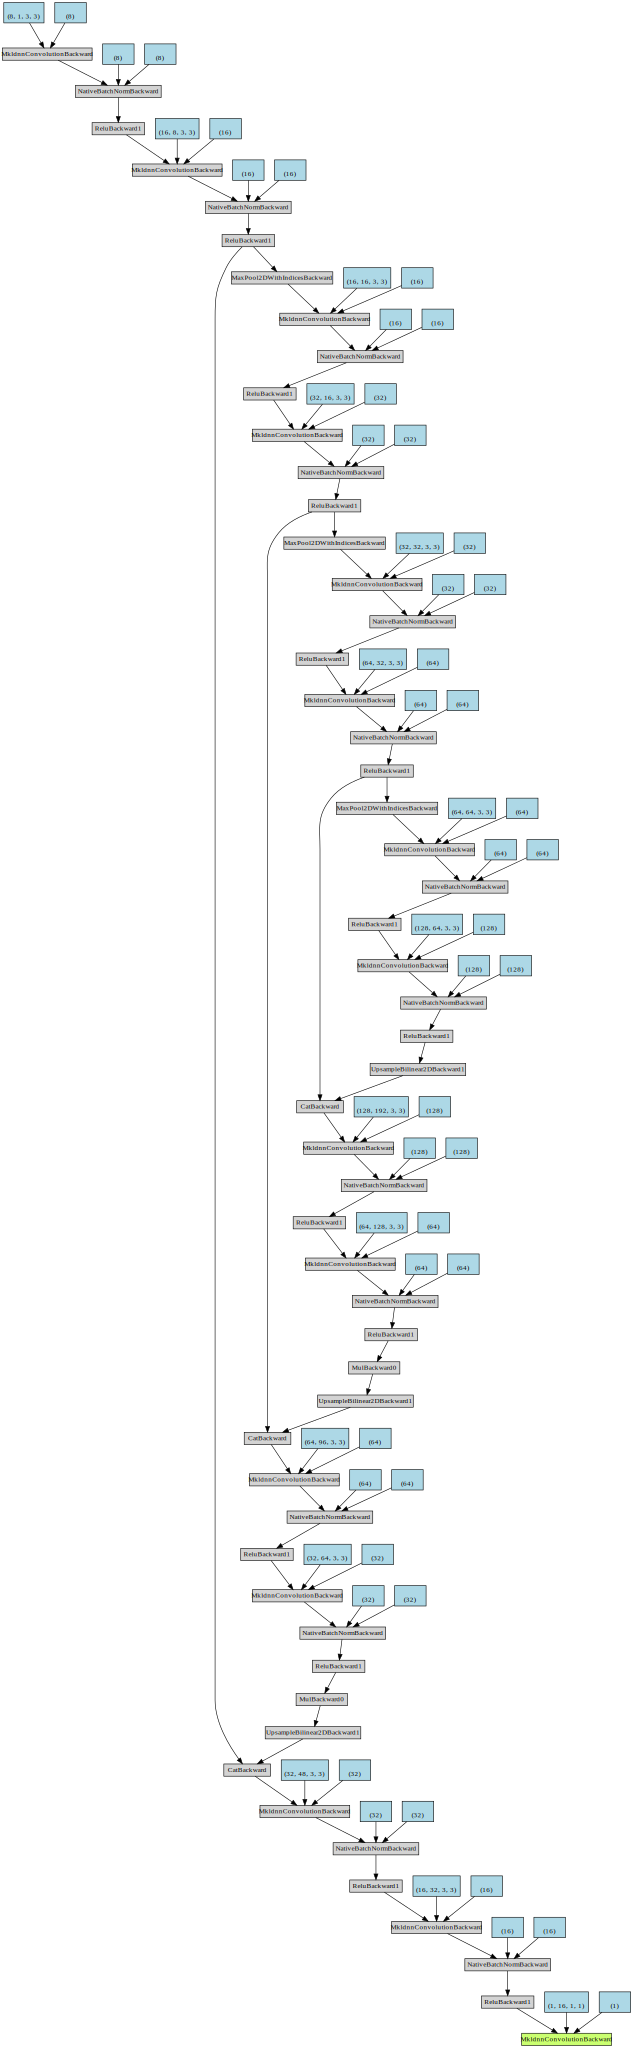

In [9]:
import torchviz
dummy_x = torch.zeros((1, 1, 512, 512), dtype=torch.float, requires_grad=False)
dummy_y = UNet(IN_CHS, OUT_CHS, UNET_DEPTH)(dummy_x)
dot = torchviz.make_dot(dummy_y)
dot.format = 'svg'
dot

### データの読み込み

## 学習

### pytorch-lightining

In [10]:
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
import os

NUM_WORKERS = 0 if os.name == 'nt' else 2
BATCH_SIZE = 8


class LitUNet(pl.LightningModule):
    def __init__(self, in_chs, out_chs, depth):
        super().__init__()
        self.model = UNet(in_chs, out_chs, depth)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

100%|██████████| 228/228 [00:00<00:00, 625.30it/s]
GPU available: True, used: True
2021-03-31 14:21:44,484 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:21:44,485 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:21:44,486 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 535 K 
-------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2021-03-31 14:21:45,619 INFO :
  | Name  | Type | Params
-------------------------------
0 | model | UNet | 535 K 
-------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params


Training: 0it [00:00, ?it/s]

2021-03-31 14:22:10,230 INFO :Finish training


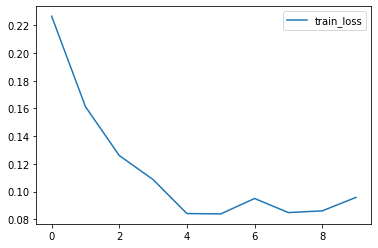

In [11]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

EPOCHS = 32
PATIENCE = 4
BATCH_SIZE = 4

model = LitUNet(IN_CHS, OUT_CHS, UNET_DEPTH)

train_data, train_labels = load_img2img_dataset(df_train, load_img)
dataset = AugmentedDataset(train_data, train_labels, random_transform)
trainloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
early_stop_callback = EarlyStopping(monitor='train_loss',
                                    patience=PATIENCE,
                                    verbose=False,
                                    mode='min')
csv_logger = CSVLogger('train_logs', name='lung_segmentation')
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else 0,
                     max_epochs=EPOCHS,
                     logger=csv_logger,
                     log_every_n_steps=len(trainloader),
                     callbacks=[early_stop_callback])

trainer.fit(model, trainloader)
logger.info('Finish training')
df_logs = pd.read_csv(csv_logger.experiment.metrics_file_path)
df_logs.plot(y='train_loss')
plt.show()

## 評価
Dice similarity coefficient(F1 score)とJaccard Index(IoU)を評価指標とする。

100%|██████████| 57/57 [00:00<00:00, 640.98it/s]


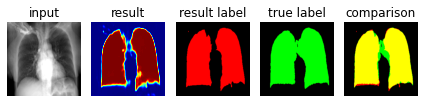

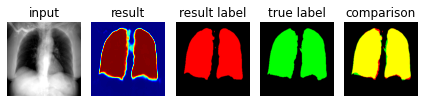

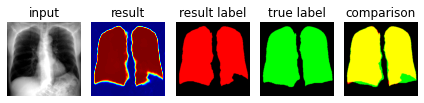

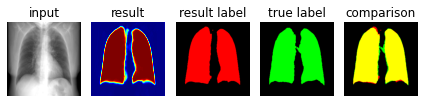

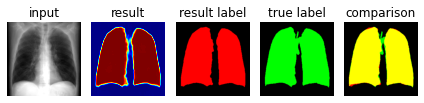

In [12]:
import math
from sklearn import metrics

label_cmap = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0], [255, 255, 0]])

test_data, test_labels = load_img2img_dataset(df_test, load_img)
test_data = (test_data / 255).astype(np.float32)
test_labels = (test_labels > 0).astype(np.uint8)

model.eval()
model.freeze()

scores = []
for i, (data, label) in enumerate(zip(test_data, test_labels)):
    data = data.transpose((2, 0, 1))[np.newaxis]
    label = label.astype(np.uint8).squeeze()
    with torch.no_grad():
        pred = torch.sigmoid(model(torch.FloatTensor(data)))
        pred = pred.cpu().numpy().squeeze()
    pred_bin = (pred > .5).astype(np.uint8)
    scores.append((metrics.f1_score(label.ravel(), pred_bin.ravel()),
                   metrics.jaccard_score(label.ravel(), pred_bin.ravel())))
    if i < N_SAMPLES:
        plt.subplot(1, 5, 1)
        plt.imshow(data.squeeze(), cmap='gray')
        plt.title('input')
        plt.axis('off')
        plt.subplot(1, 5, 2)
        plt.imshow(pred, cmap='jet')
        plt.title('result')
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(label_cmap[[0, 1]][pred_bin.astype(np.uint8).squeeze()])
        plt.title('result label')
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.imshow(label_cmap[[0, 2]][label.astype(np.uint8)])
        plt.title('true label')
        plt.axis('off')
        plt.subplot(1, 5, 5)
        plt.imshow(label_cmap[pred_bin + label * 2])
        plt.title('comparison')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [13]:
df_score = pd.DataFrame(scores,
                        columns=['dice coefficient', 'jaccard index'],
                        index=test_index)
display(df_score.head())
display(
    pd.DataFrame({
        'median': df_score.median(),
        'mean': df_score.mean(),
        'std': df_score.std(),
        'min': df_score.min(),
        'max': df_score.max(),
    }))

,dice coefficient,jaccard index
3,0.950875,0.906350
6,0.967842,0.937688
8,0.953858,0.911786
15,0.967562,0.937163
16,0.977982,0.956913


,median,mean,std,min,max
dice coefficient,0.964382,0.958509,0.020099,0.856683,0.979253
jaccard index,0.931214,0.920995,0.035363,0.749295,0.959349


### 分布の確認
Dice similarity coefficientの分布を表示する。

#### ヒストグラム

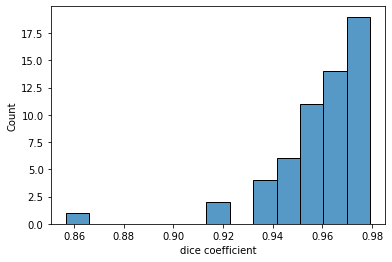

In [14]:
import seaborn as sns
sns.histplot(x=df_score['dice coefficient'])
plt.show()

#### Boxplot

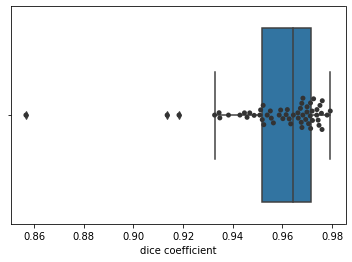

In [15]:
sns.boxplot(x='dice coefficient', data=df_score)
sns.swarmplot(x='dice coefficient', data=df_score, color='.2')
plt.show()

#### Letter value plot

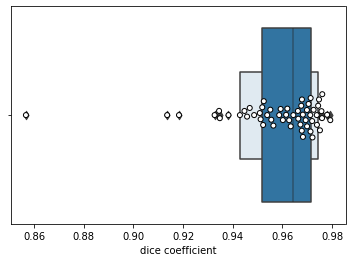

In [16]:
sns.boxenplot(x='dice coefficient', data=df_score)
sns.swarmplot(x='dice coefficient',
              data=df_score,
              color='white',
              edgecolor='black',
              linewidth=1)
plt.show()

#### Violinplot

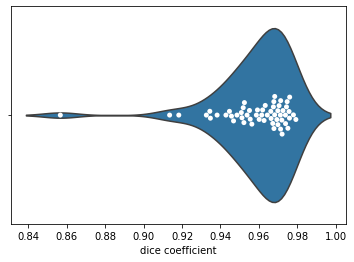

In [17]:
sns.violinplot(x='dice coefficient', data=df_score, inner=None)
sns.swarmplot(x='dice coefficient',
              data=df_score,
              color='white',
              edgecolor='gray')
plt.show()